# Exercise 3: Earthquake Magnitude-Frequency Analysis Near Antananarivo

This notebook demonstrates how to analyze the frequency and magnitude of earthquakes near Antananarivo, Madagascar, using real earthquake catalog data. The workflow includes:

- **Data Acquisition:** Earthquake events are fetched from the USGS catalog for a region surrounding Antananarivo, defined by latitude and longitude bounds, and filtered by minimum magnitude.
- **Data Cleaning:** Events with missing depth or magnitude information are removed to ensure data quality.
- **Distance Calculation:** The haversine formula is used to compute the distance from each earthquake to Antananarivo.
- **Magnitude Binning:** Earthquake magnitudes are grouped into bins (0.5 increments), and the number of events in each bin is counted.
- **Magnitude-Frequency Distribution:** The cumulative number of events above each magnitude threshold is calculated and visualized, showing the typical decrease in frequency with increasing magnitude.
- **Gutenberg-Richter Law Fitting:** The Gutenberg-Richter relation (`log10(N) = a - b*M`) is fitted to the magnitude-frequency data, providing estimates for the parameters `a` and `b` that characterize the seismicity of the region.
- **Data Filtering:** The analysis is repeated for events with magnitude ≥ 4.0 to focus on more significant earthquakes.

This exercise illustrates key concepts in seismology and statistical analysis, including catalog querying, data wrangling, binning, cumulative distributions, and linear regression fitting for empirical laws. The workflow is modular and can be adapted to other regions or magnitude thresholds.

First, we need to install the required packages.

In [1]:
# 1) Install dependencies if missing
import sys, subprocess, importlib

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
        print(f"[ok] {pkg} already installed")
    except Exception:
        print(f"[info] Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        importlib.import_module(name)
        print(f"[ok] {pkg} installed")


pkgs = ["os", "re", "requests", "zipfile", "geopandas",
        "matplotlib", "shapely", "cartopy", "obspy", 
        "folium", "osmnx", "numpy", "pandas"]

for pkg in pkgs:
    ensure(pkg)

[ok] os already installed
[ok] re already installed
[ok] requests already installed
[ok] zipfile already installed
[ok] geopandas already installed
[ok] matplotlib already installed
[ok] shapely already installed
[ok] cartopy already installed
[ok] obspy already installed
[ok] folium already installed
[ok] osmnx already installed
[ok] numpy already installed
[ok] pandas already installed


# Import required libraries

In the next cell, we will import the required packages and define the parameters and constants needed for the exercise.

In [2]:
#%% Imports and constants
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt, log10, log, exp
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import geopandas as gpd
import requests, zipfile, io
from obspy.geodetics import gps2dist_azimuth
import pandas as pd

# Constants
R_EARTH_KM = 6371.0  # Earth radius in kilometers

# City of interest
CITY_NAME = "Antananarivo"
CITY_LAT = -18.9
CITY_LON = 47.5

# Earthquake catalog search parameters
MIN_LAT = -26.0
MAX_LAT = -11.0
MIN_LON = 42.0
MAX_LON = 51.0
START_DATE = UTCDateTime(1900, 1, 1)
END_DATE = UTCDateTime.now()
MIN_MAG = 3.0

# Fetching and Cleaning Earthquake Catalog Data

In this step, we query the USGS earthquake catalog for events within the specified latitude and longitude bounds around Antananarivo, Madagascar, and within the defined time and magnitude range. We then filter out events that lack depth or magnitude information to ensure the dataset is suitable for further analysis. The resulting catalog contains only earthquakes with complete and reliable data.

In [3]:
#%% Fetch earthquake catalog using ObsPy
client = Client("USGS")
catalog = client.get_events(starttime=START_DATE, endtime=END_DATE,
                            minlatitude=MIN_LAT, maxlatitude=MAX_LAT,
                            minlongitude=MIN_LON, maxlongitude=MAX_LON,
                            minmagnitude=MIN_MAG)
print(f"Fetched {catalog.count()} earthquake events from the catalog")

# Remove events with missing depth or magnitude
catalog = [event for event in catalog if event.origins and event.magnitudes and
           event.origins[0].depth is not None and event.magnitudes[0].mag is not None]
print(f"Number of events with depth and magnitude information: {len(catalog)}")

Fetched 297 earthquake events from the catalog
Number of events with depth and magnitude information: 297


# Calculating Distances and Preparing Event Data

In this step, we calculate the distance from each earthquake event to Antananarivo using the haversine formula, which accounts for the curvature of the Earth. We then extract relevant event attributes—latitude, longitude, depth, magnitude, and computed distance—and organize them into a GeoDataFrame for spatial analysis. This structured dataset enables further statistical and geographic exploration of earthquake patterns near Antananarivo.

In [4]:
#%% Calculate distances from city to each event
# Function to calculate haversine distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = R_EARTH_KM * c
    return km

#%% Extract event data (latitude, longitude, depth, magnitude, distance)
# into geopandas dataframe
event_data = []
for event in catalog:
    origin = event.origins[0]
    magnitude = event.magnitudes[0].mag if event.magnitudes else None
    if origin and magnitude is not None:
        event_data.append({
            "latitude": origin.latitude,
            "longitude": origin.longitude,
            "depth_km": origin.depth / 1000.0,  # convert to km
            "magnitude": magnitude,
            "distance": haversine(CITY_LAT, CITY_LON, origin.latitude, origin.longitude)
        })

events_gdf = gpd.GeoDataFrame(event_data, geometry=gpd.points_from_xy(
    [e["longitude"] for e in event_data],
    [e["latitude"] for e in event_data]
))

print(f"Prepared GeoDataFrame with {len(events_gdf)} events")

Prepared GeoDataFrame with 297 events


# Magnitude Binning and Frequency Analysis

In this section, earthquake events are grouped into magnitude bins with 0.5 increments. The number of events in each bin is counted, and a cumulative count is calculated to show how many earthquakes have magnitudes greater than or equal to each bin threshold. This cumulative distribution is a key step in understanding the frequency of larger earthquakes in the region. The results are visualized using a histogram and a magnitude-frequency scatter plot, which reveal the typical decrease in event frequency with increasing magnitude.

  magnitude_bin  event_count  bin_center  cumulative_count  log_counts
0    (3.0, 3.5]            0        3.25               297    2.472756
1    (3.5, 4.0]            4        3.75               297    2.472756
2    (4.0, 4.5]          156        4.25               293    2.466868
3    (4.5, 5.0]          107        4.75               137    2.136721
4    (5.0, 5.5]           22        5.25                30    1.477121
5    (5.5, 6.0]            5        5.75                 8    0.903090
6    (6.0, 6.5]            3        6.25                 3    0.477121


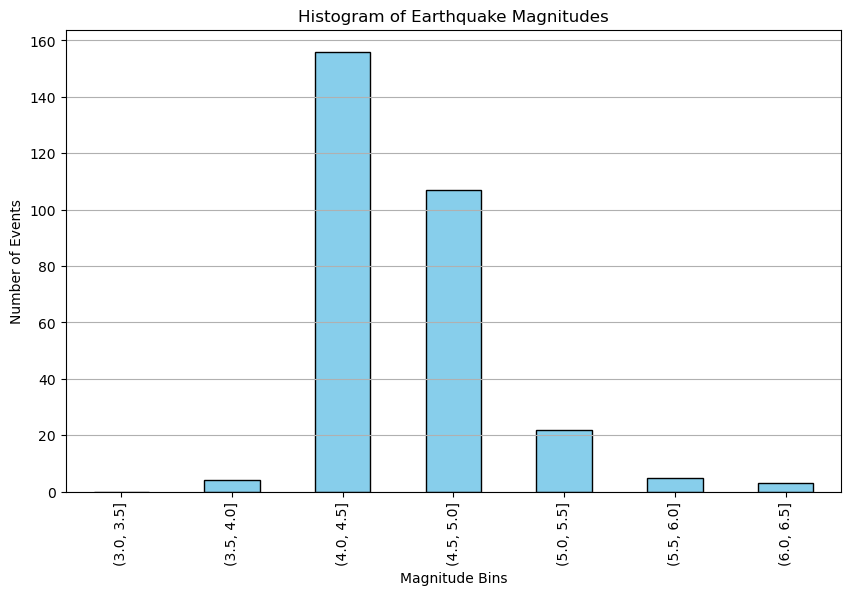

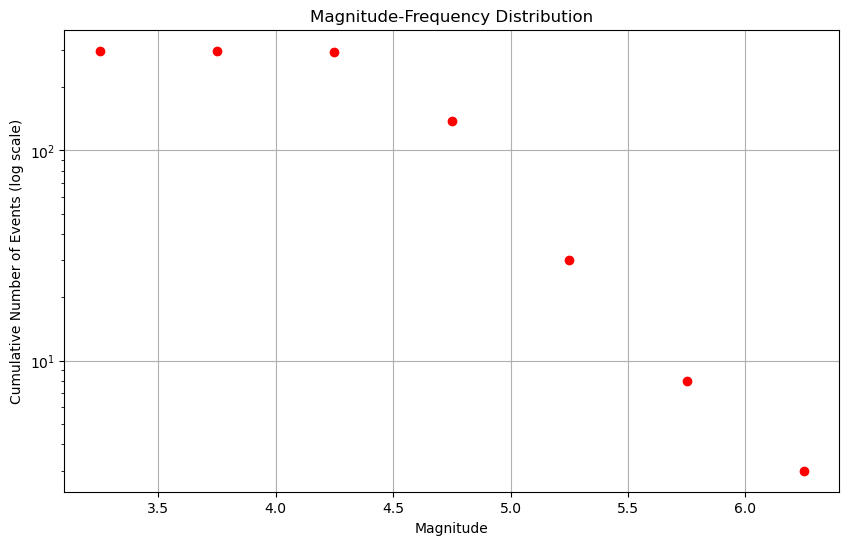

In [6]:
#%% Classify events by magnitude into bins with 0.5 increments
# and get the count of events in each bin

bins = np.arange(MIN_MAG, max(events_gdf['magnitude']) + 0.5, 0.5)
events_gdf['mag_bin'] = pd.cut(events_gdf['magnitude'], bins)
mag_bin_counts = events_gdf['mag_bin'].value_counts().sort_index()
mag_bins_centers = bins[:-1] + 0.25  # center of each bin


# Make a new data frame for better with the bins, number of events, bin centers,
# and cumulative counts from the largest to smallest magnitude
mag_bin_df = pd.DataFrame({
    'magnitude_bin': mag_bin_counts.index.astype(str),
    'event_count': mag_bin_counts.values,
    'bin_center': bins[:-1] + 0.25  # center of each bin
})
cum_counts = mag_bin_df['event_count'][::-1].cumsum()[::-1]
mag_bin_df['cumulative_count'] = cum_counts.values

# Add a column for log10 of cumulative counts, replacing 0 with NaN to avoid -inf
# Calculate log10 of cumulative counts, handling zero counts
log_counts = lambda x: log10(x) if x > 0 else np.nan
mag_bin_df['log_counts'] = mag_bin_df['cumulative_count'].replace(0, np.nan).apply(log_counts)
print(mag_bin_df)

# Plot histogram of event counts by magnitude bins
plt.figure(figsize=(10, 6))
mag_bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Magnitude Bins")
plt.ylabel("Number of Events")
plt.title("Histogram of Earthquake Magnitudes")
plt.grid(axis='y')
plt.show()

#%% Calculate and plot magnitude-frequency distribution
# Plot magnitude-frequency distribution
plt.figure(figsize=(10, 6))
plt.scatter(mag_bins_centers, cum_counts, color='red')
plt.yscale('log')
plt.xlabel("Magnitude")
plt.ylabel("Cumulative Number of Events (log scale)")
plt.title("Magnitude-Frequency Distribution")
plt.grid()
plt.show()


# Fitting the Gutenberg-Richter Law

In this step, we fit the Gutenberg-Richter relation to the magnitude-frequency data. The Gutenberg-Richter law describes the relationship between earthquake magnitude and the cumulative number of events, expressed as `log10(N) = a - b*M`, where `N` is the cumulative count and `M` is magnitude. By performing linear regression on the log-transformed cumulative counts versus magnitude bin centers, we estimate the parameters `a` and `b`, which characterize the seismicity of the region. The observed data and the fitted model are visualized together to assess the fit quality.

Fitted Gutenberg-Richter parameters: a = 5.20, b = 0.72


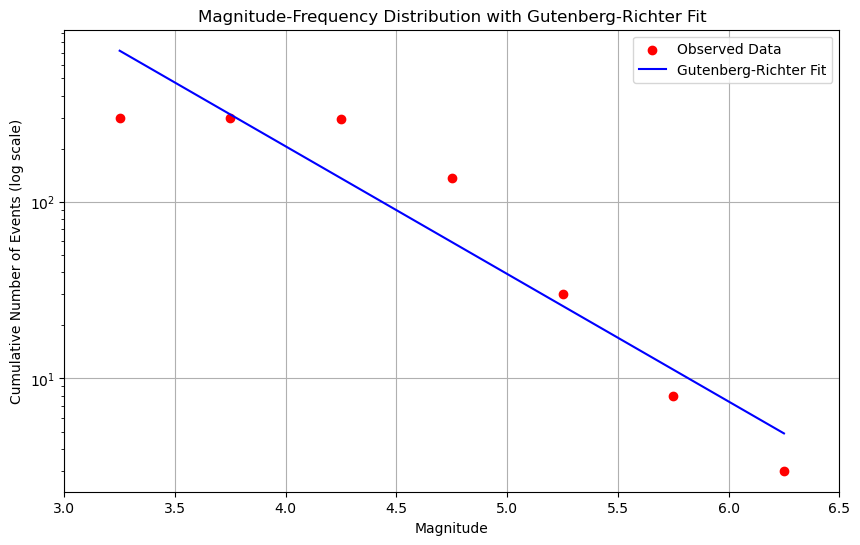

In [7]:
#%% Fit Gutenberg-Richter relation to the magnitude-frequency data
# Gutenberg-Richter relation: log10(N) = a - b*M
# where N is the cumulative number of events with magnitude >= M
# We can fit a linear model to log10(N) vs M to estimate a and b
from scipy.stats import linregress

log_counts = np.log10(cum_counts)
slope, intercept, r_value, p_value, std_err = linregress(mag_bins_centers, log_counts)
b_value = -slope
a_value = intercept 
print(f"Fitted Gutenberg-Richter parameters: a = {a_value:.2f}, b = {b_value:.2f}")
# Plot fitted line
plt.figure(figsize=(10, 6))
plt.scatter(mag_bins_centers, cum_counts, color='red', label='Observed Data')
plt.yscale('log')
plt.xlim((MIN_MAG, max(bins)))
plt.xlabel("Magnitude")
plt.ylabel("Cumulative Number of Events (log scale)")
plt.title("Magnitude-Frequency Distribution with Gutenberg-Richter Fit")
plt.grid()
# Plot fitted line
fitted_counts = 10**(a_value - b_value * mag_bins_centers)
plt.plot(mag_bins_centers, fitted_counts, color='blue', label='Gutenberg-Richter Fit')
plt.legend()
plt.show()

## Filtering for Significant Earthquakes (Magnitude ≥ 4.0)

We will focus the analysis on a more complete record and impactful seismic events, we filter the earthquake catalog to include only those with magnitude greater than or equal to 4.0. Events with magnitude less than 4.0 are fewer and missing, which does not match the general observation that the number of earthquakes increases as the magnitude decreases. This is mainly related to the lack or limited number of seismological stations in the region. This step reduces the influence of smaller, less significant earthquakes and allows for a clearer examination of the magnitude-frequency relationship among moderate and large events. The filtered dataset is used to recalculate magnitude bins, cumulative counts, and to visualize the updated magnitude-frequency distribution. This targeted approach provides more meaningful insights into the seismic hazard near Antananarivo.

  magnitude_bin  event_count  bin_center  cumulative_count  log_counts
2    (4.0, 4.5]          156        4.25               293    2.466868
3    (4.5, 5.0]          107        4.75               137    2.136721
4    (5.0, 5.5]           22        5.25                30    1.477121
5    (5.5, 6.0]            5        5.75                 8    0.903090
6    (6.0, 6.5]            3        6.25                 3    0.477121


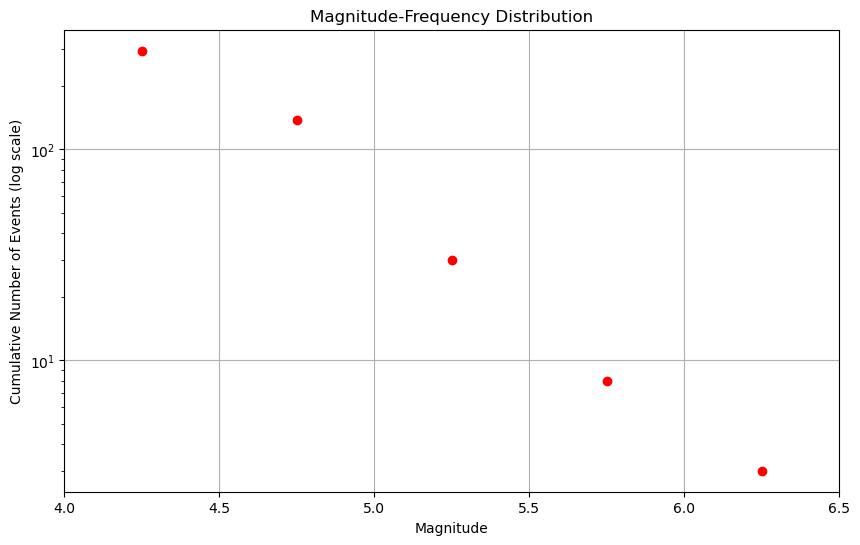

In [8]:
#%% Remove events with magnitude less than 4.0
events_gdf = mag_bin_df[mag_bin_df['bin_center'] >= 4.0]
print(events_gdf)

# Recalculate magnitude bins and cumulative counts
# Plot magnitude-frequency distribution
plt.figure(figsize=(10, 6))
plt.scatter(events_gdf['bin_center'], events_gdf['cumulative_count'], color='red')
plt.yscale('log')
plt.xlabel("Magnitude")
plt.xlim((4.0, max(bins)))
plt.ylabel("Cumulative Number of Events (log scale)")
plt.title("Magnitude-Frequency Distribution")
plt.grid()
plt.show()

# Gutenberg-Richter Law Fit for Significant Earthquakes

In this step, we fit the Gutenberg-Richter relation to the filtered magnitude-frequency data (magnitude ≥ 4.0). The linear regression is performed on the log-transformed cumulative event counts versus the magnitude bin centers. The resulting parameters `a` and `b` quantify the seismicity for moderate and large earthquakes near Antananarivo. The plot displays both the observed cumulative counts and the fitted Gutenberg-Richter model, allowing visual assessment of the fit and interpretation of regional earthquake occurrence rates.

Fitted Gutenberg-Richter parameters after cleaning: a = 6.97, b = 1.04


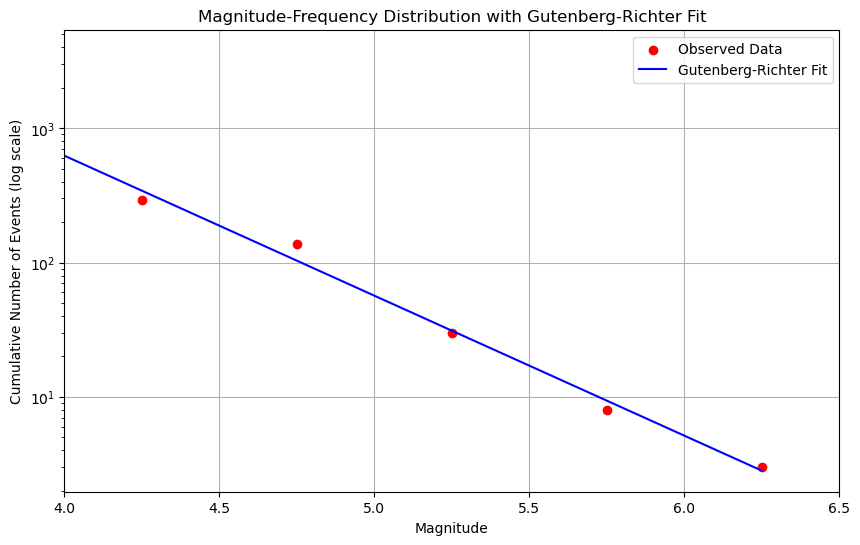

In [9]:
# %% Fit Gutenberg-Richter relation to the new magnitude-frequency data
# Gutenberg-Richter relation: log10(N) = a - b*M
# where N is the cumulative number of events with magnitude >= M
# We can fit a linear model to log10(N) vs M to estimate a and b
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(events_gdf['bin_center'], events_gdf['log_counts'])
b_value = -slope
a_value = intercept 
print(f"Fitted Gutenberg-Richter parameters after cleaning: a = {a_value:.2f}, b = {b_value:.2f}")
# Plot fitted line
plt.figure(figsize=(10, 6))
plt.scatter(events_gdf['bin_center'], events_gdf['cumulative_count'], color='red', label='Observed Data')
plt.yscale('log')
plt.xlabel("Magnitude")
plt.xlim((4.0, max(bins)))
plt.ylabel("Cumulative Number of Events (log scale)")
plt.title("Magnitude-Frequency Distribution with Gutenberg-Richter Fit")
plt.grid()
# Plot fitted line
fitted_counts = 10**(a_value - b_value * mag_bins_centers)
plt.plot(mag_bins_centers, fitted_counts, color='blue', label='Gutenberg-Richter Fit')
plt.legend()
plt.show()

# Extra tasks:
* Did you observe variation in the a and b parameters based on the input? Why does this variation occur?
* What is the effect of binning? Try redoing the analysis with different bins, e.g., with a 0.2 interval.
* Did you observe variation in the a and b estimates?
* What does this tell you about the importance of the completeness of earthquake catalogs?
* Are you aware of other fitting approaches? Try them. For example, you could use the numpy.polyfit function.
* Is there any difference between the a and b estimates using numpy.polyfit and the scipy linregress function used here?
* In your opinion, what is more important: the choice of bins or the fitting function?
